# Maximum Likelihood Classifier implementation
Created for the bachelor thesis of Jakub Dvorak | jakub.dvorak@natur.cuni.cz<br>
Department of Applied Geoinformatics and Cartography, Faculty of Science, Charles University

Adapted from EduServ18 (2020): 3D Sensing, Scene Reconstruction and Semantic Interpretation<br>
The original code was created by Martin Weinmann, Franz Rottensteiner and Dennis Wittich

__imports__ and __settings__:

In [1]:
# IMPORTS
import os
import numpy as np
from time import time as time
import imageio
import matplotlib
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB

# GLOBAL SETTINGS
PlotSize = 8                                     # Size of plots
matplotlib.rcParams['figure.figsize'] = [PlotSize*2, PlotSize]  
CMAP = matplotlib.colors.ListedColormap(['black', 'white', 'orange'])               # Color mapping 
np.set_printoptions(precision=2, suppress=True)  # Array print precision

# CLASS AND FEATURE DESCRIPTION
class_names = ['BACKGRD','PINUS','PICEA']
feature_names = ['NIR','RED','GREEN']
num_classes = len(class_names); num_features = len(feature_names)

# PATHS TO TRAIN/TEST DATA
data_path = '../data/01_99/'
training_set_path = data_path + 'train/'         # Relative path to training patch root folder
test_set_path =     data_path + 'test/'         # Relative path to test patch root folder

num_of_training_tiles = len(os.listdir(training_set_path + 'CIR/'))
num_of_test_tiles = len(os.listdir(test_set_path + 'CIR/'))

# USE CIR OR RGB DATA
use_cir = True
use_rgb = True
patch_size = 512

## Data import and handling
Following function reads input data and creates numpy arrays out of it

In [2]:
def read_patch(root_folder, cir, rgb):
    ##########################################################
    # READ IMAGES as FLOAT
    if cir:
        cir_file_list = os.listdir(root_folder + 'CIR/')
        cir_list = []
        
        for file in cir_file_list:
            cir_patch = imageio.imread(root_folder + 'CIR/' + file).astype(np.float32)
            cir_patch = cir_patch * 1/255
            
            h, w = cir_patch.shape[:2]
            num_samples = h*w
            cir_list.append(cir_patch[:,:,:].reshape((num_samples, 3)))
            del cir_patch

        cir_features = np.concatenate(cir_list, axis=0)
    
    if rgb:
        rgb_file_list = os.listdir(root_folder + 'RGB/')
        rgb_list = []
        
        for file in rgb_file_list:
            rgb_patch = imageio.imread(root_folder + 'RGB/' + file).astype(np.float32)
            rgb_patch = rgb_patch * 1/255
            
            h, w = rgb_patch.shape[:2]
            num_samples = h*w
            rgb_list.append(rgb_patch[:,:,:].reshape((num_samples, 3)))
            del rgb_patch
        
        rgb_features = np.concatenate(rgb_list, axis=0)


    if cir and rgb:
        features = np.concatenate([cir_features, rgb_features], axis=1)
    elif cir:
        features = cir_features
    elif rgb:
        features = rgb_features
    else:
        print('No valid data input.')


    gt_file_list = os.listdir(root_folder + 'GT/')
    gt_list = []

    for file in gt_file_list:
        gt_patch = imageio.imread(root_folder + 'GT/' + file).astype(np.float32)
 
        h, w = gt_patch.shape[:2]
        num_samples = h*w
    
        gt_list.append(gt_patch[:,:].reshape((num_samples)))
        del gt_patch

    ground_truth = np.concatenate(gt_list, axis=0)

    ########################################################## 
    return features, ground_truth

In [3]:
a = time()
X, y = read_patch(training_set_path, use_cir, use_rgb)
b = time()
X_t, y_t = read_patch(test_set_path, use_cir, use_rgb)
c = time()

print('Training set loaded in ' + str(b-a) + 's')
print('Testing set loaded in ' + str(c-b) + 's')
print(X.shape)
print(y.shape)
print(X.max())
print(X.min())

Training set loaded in 2.2849271297454834s
Testing set loaded in 39.44927215576172s
(3407872, 6)
(3407872,)
1.0
0.0


## Visualisation function
The following function visualises IRRG, ground truth and predicted labels

In [4]:
def plot_rgb_cir_gt_pred(tile_index, data, gt, pred, num_of_tiles, cir, rgb, size):
    # Function to plot prediction vs ground truth
    
    # Split the datasets into tiles
    data_list = np.split(data, num_of_tiles)
    gt_list =   np.split(gt,   num_of_tiles)
    pred_list = np.split(pred, num_of_tiles)
    
    # Select tile by tile_index and reshape to original dimensions
    data = data_list[tile_index].reshape((size,size,data.shape[1]))
    gt   = gt_list[tile_index].reshape((size,size))
    pred = pred_list[tile_index].reshape((size,size))
    
    # Plotting
    plt.figure(facecolor='white')
    
    if cir and rgb:
        plt.subplot(1, 4, 1)
        plt.imshow(data[:,:,:3])
        plt.title('NIR Red Green composite')
        plt.axis('off')

        plt.subplot(1, 4, 2)
        plt.imshow(data[:,:,-3:])
        plt.title('Red Green Blue composite')
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.imshow(gt, CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 4, 4)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')
    
    elif cir or rgb:
        plt.subplot(1, 3, 1)
        plt.imshow(data)
        if cir:
            plt.title('NIR Red Green composite')
        else:
            plt.title('Red Green Blue composite')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(gt, CMAP)
        plt.title('GT Labels')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(pred, CMAP)
        plt.title('Predicted Labels')
        plt.axis('off')

In [ ]:
plot_rgb_cir_gt_pred(8, X, y, y, num_of_training_tiles, use_cir, use_rgb, patch_size)

## Accuracy metrics
The following function returns accuracy metrics, namely overall accuracy, precision, recall and f1 score

In [5]:
def compute_quality_metrics(Y, y, C):
    # Copy the code from the last lab here
    ##########################################################
    M = np.equal(Y,y).astype(np.int)
    TP = np.array([np.sum( M * (Y==i).astype(np.int)) for i in range(C)])
    FP = np.array([np.sum( (1-M) * (Y==i)) for i in range(C)])
    FN = np.array([np.sum( (1-M) * (y==i)) for i in range(C)])

    precisions = TP/(TP+FP)
    recalls = TP/(TP+FN)
    f1_scores = 2 * precisions * recalls / (precisions + recalls)
    overall_accuracy = np.sum(Y==y) / len(y)
    mean_f1_score = np.mean(f1_scores)
    return precisions, recalls, f1_scores, overall_accuracy, mean_f1_score, TP, FP, FN
    ##########################################################

## Maximum Likelihood Classifier
MLC in Remote Sensing is equivalent to Linear Discriminant Analysis (LDA)

In [6]:
# Generate the MLC
mlc = GaussianNB()

# Train the classifier
a = time()
mlc.fit(X, y) #X_es, y_es
b = time()

print('Training finished in ' + str(b-a) + 's')

Training finished in 0.6442821025848389s


In [17]:
a = time()
Y_t = mlc.predict(X_t).astype(np.uint8)
b = time()

print('Inferrence finished in ' + str(b-a) + 's')

Inferrence finished in 159.41205954551697s


In [18]:
precisions, recalls, f1_scores, overall_accuracy, mean_f1_score,TrueP, FalseP, FalseN = compute_quality_metrics(Y_t, y_t, 3)
print('precisions [%]:      ', precisions*100)
print('recalls    [%]:      ', recalls*100)
print('f1_scores  [%]:      ', f1_scores*100)
print('')
print('overall accuracy: {:.2%}'.format(overall_accuracy))
print('mean f1 score:    {:.2%}'.format(mean_f1_score))
print('True Positive:' + str(TrueP) + '\nFalse Positive:' + str(FalseP) + '\nFalse Negative:' + str(FalseN))

precisions [%]:       [83.91 47.34 11.25]
recalls    [%]:       [61.8  60.74 27.52]
f1_scores  [%]:       [71.18 53.21 15.97]

overall accuracy: 59.32%
mean f1 score:    46.78%
True Positive:[131668895  56055907   5710627]
False Positive:[25248475 62356950 45066282]
False Negative:[81397649 36230707 15043351]


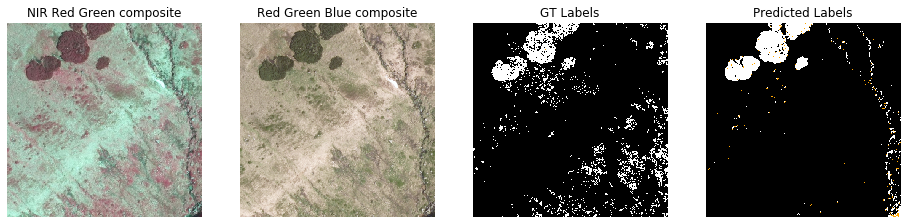

In [9]:
plot_rgb_cir_gt_pred(40, X_t, y_t, Y_t, num_of_test_tiles, use_cir, use_rgb, patch_size)

In [10]:
# save the result
np.savetxt(data_path + 'results/mlc.csv', Y_t, fmt='%d')

In [19]:
Y_t.dtype

dtype('uint8')

In [22]:
imageio.imwrite(data_path + 'results/mlc.tif', Y_t.reshape(2,int(Y_t.shape[0]/2)))